import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

X is the feature from column V, normalised by subtracting the mean and dividing by std deviation. Y is the target variable.

In [25]:
dataframe = pd.read_excel('dataset1/dataset1.xlsx')
X = dataframe['V'].sort_values()
X = (X - X.mean()) / X.std()
y = dataframe['AT'][X.index].values
y = (y - y.mean()) / y.std()
X = np.reshape(X.values, (-1, 1))

In [26]:
# Polynomial Basis Function Transformation to generate polynomial features, X^0 to X^(h-1)
def polynomial_basis_function_transformation(X, h):
    powers = np.arange(h)
    X_poly = np.power(X, powers)
    return X_poly

In [27]:
# Shuffle Data
def shuffle_data(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], y[indices]

Step one of stochastic gradient descent: 
- Calculating the predicted value and gradient for each sample in the batch
- Update weights on the basis of gradient and learning rate lr

In [31]:
# SGD Function
def sgd_thread_worker(X, y, weights, lr):
    for i in range(len(X)):
        y_pred = np.dot(X[i], weights)
        gradient = (y_pred - y[i]) * X[i]
        weights -= lr * gradient
    return weights

ThreadPoolExecutor has been used to apply SGD in parallel on the batches. Each thread has performed its own gradient descent. 
MSE has been calculated for each epoch to measure progress

In [33]:
def parallel_sgd(X, y, h, lr, epochs, num_threads):
    X_poly = polynomial_basis_function_transformation(X, h)
    weights = np.zeros(X_poly.shape[1])  # Initialize weights
    batch_size = len(X_poly) // num_threads

    mse_history = []

    for epoch in range(epochs):
        # Shuffle data each epoch
        X_poly, y = shuffle_data(X_poly, y)

        # Split data into thread-sized batches
        batches = [(X_poly[i:i + batch_size], y[i:i + batch_size]) for i in range(0, len(X_poly), batch_size)]

        # Process batches in parallel
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = [executor.submit(sgd_thread_worker, X_batch, y_batch, weights, lr) for X_batch, y_batch in batches]
            for future in futures:
                weights += future.result() / num_threads  # Aggregate weights

        # Calculate MSE for monitoring
        y_pred = np.dot(X_poly, weights)
        mse = mean_squared_error(y, y_pred)
        mse_history.append(mse)

    return weights, mse_history


In [54]:
def plot_mse_vs_epochs(X, y, h, lr, epochs, num_threads=4):
    weights, mse_history = parallel_sgd(X, y, h, lr, epochs, num_threads)

    plt.plot(range(epochs), mse_history, label=f"h={h}, lr={lr}, threads={num_threads}")
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE vs Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

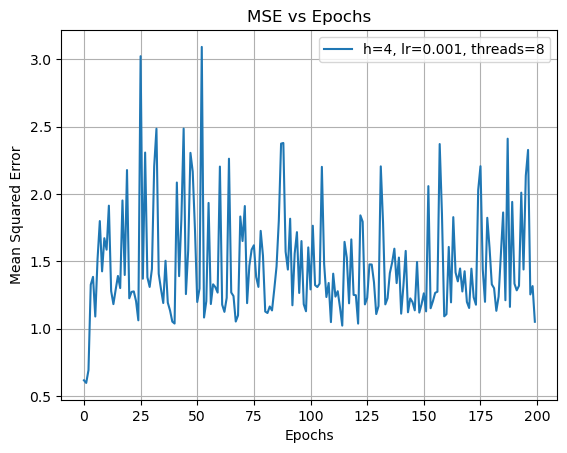

In [39]:
plot_mse_vs_epochs(X, y, h=4, lr=0.001, epochs=200, num_threads=4)